In [170]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [171]:
#Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import os
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot

from pandas import read_csv
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error, mean_absolute_error
#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

from openpyxl import load_workbook
from statsmodels.tsa.statespace.sarimax import SARIMAX
import math
# Read the Excel file
from datetime import datetime

#Processing data

In [172]:
population_data_link = "/content/drive/MyDrive/Capstone Project/Population_estimates_2023.csv"
columns_to_drop = ['DGUID', 'UOM','UOM_ID','SCALAR_FACTOR','SCALAR_ID','SCALAR_ID','VECTOR','COORDINATE','STATUS','SYMBOL','TERMINATED','DECIMALS']
population_data_main = pd.read_csv(population_data_link)
population_data_main = population_data_main.drop(columns_to_drop, axis=1)
dataset_new=[]
predicted_values_df=[]
predicted_values_list=[]

forecasted_values_list=[]
forecasted_values_df=[]
construction_copy_main = pd.read_excel("/content/drive/MyDrive/CapstoneOntarioFinalModels/Construction2020-2023.xlsx")
#'Yukon', 'Prince Edward Island','Northwest Territories'  -- data is incomplete for construction dataset for 2023
geo_names = [
    'Nova Scotia',
    'New Brunswick',
    'Quebec',
    'Ontario',
    'Manitoba',
    'Saskatchewan',
    'Alberta',
    'British Columbia',
    'Canada'
    # 'Newfoundland and Labrador',
    # 'Nunavut',
    # 'Prince Edward Island',
    # 'Yukon'
]


In [173]:
def process_geo_for_population(geo_name):
    population_data = population_data_main
    population_data = population_data[population_data['GEO'] == geo_name]
    population_data.head(2)

    from statsmodels.tsa.seasonal import seasonal_decompose
    # Perform additive decomposition
    decomp = seasonal_decompose(population_data['VALUE'],period=12)

    # Plot decomposition
    decomp.plot()
    plt.show()
    result = adfuller(population_data['VALUE'])
    print(result)

    #change House_total_price to House_only_total and Land_only_total one by one and run all to see forecast
    selected_data = population_data[['REF_DATE', 'VALUE']]
    selected_data = selected_data.sort_values(by='REF_DATE')

    # Assuming selected_data is your DataFrame

    # Convert 'REF_DATE' column to datetime
    selected_data['REF_DATE'] = pd.to_datetime(selected_data['REF_DATE'])

    # Select data with a year less than 2023
    selected_data = selected_data[selected_data['REF_DATE'].dt.year >= 2018]
    selected_data = selected_data[selected_data['REF_DATE'].dt.year <= 2023]
    selected_data.head(2)
    selected_data.set_index('REF_DATE', inplace=True)
    selected_data = selected_data.sort_index()

    # Fit a new ARIMA model using the optimal parameters and the entire train_data
    p, q, d = 1, 1, 2  # Default value

    if(geo_name == "Nova Scotia"):
      p, q, d = 1, 1, 1  # Default value
    elif(geo_name == "Ontario"):
      p, q, d = 1, 1, 1  # Default value
    elif(geo_name == "Quebec"):
      p, q, d = 1, 1, 1 # Default value
    elif(geo_name == "New Brunswick"):
      p, q, d = 1, 1, 0 # Default value

    model = SARIMAX(selected_data, order=(p,d,q), seasonal_order=(p, d, q,4))

    model_fit = model.fit()

    # Forecast for the next 12 months
    forecast_steps = 4
    forecast = model_fit.forecast(steps=forecast_steps)

    # Print the forecasted values
    print("Forecasted Values for the Next 12 Months:")
    print(forecast)
    forecast_df = pd.DataFrame(forecast)
    for index, row in forecast_df.iterrows():
      forecasted_value = row['predicted_mean']
      # Parse the string to a datetime object
      forecasted_date = datetime.strftime(index, '%Y-%m-%d')
      # # Format the datetime object as 'yyyy-MM-dd' string
      # formatted_forecasted_value = forecasted_date.strftime('%Y-%m-%d')
      new_row = {'REF_DATE': forecasted_date, 'GEO':geo_name, 'VALUE': forecasted_value}
      new_row_df = pd.DataFrame([new_row])
      forecasted_values_list.append(new_row_df)

    # Plotting historical data and forecasted values
    plt.figure(figsize=(12, 6))
    plt.plot(selected_data.index, selected_data['VALUE'], label='Historical Data')
    plt.plot(forecast.index, forecast, label='Forecast', color='red')
    plt.xlabel('Date')
    plt.ylabel('Population')
    plt.title('ARIMA Forecast for the Next 12 Months for '+geo_name)
    plt.legend()
    plt.grid(True)

    # Set x-axis limits to ensure it starts from the earliest date
    plt.show()

    import numpy as np

    # Calculate Absolute Percentage Error
    absolute_percentage_error = np.abs((selected_data['VALUE'].iloc[-forecast_steps:] - forecast) / selected_data['VALUE'].iloc[-forecast_steps:])

    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = np.mean(absolute_percentage_error) * 100

    # Print the MAPE

    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    # Splitting the data into train and test sets
    train_size = int(len(selected_data) * 0.8)  # Using 80% of the data for training
    train_data, test_data = selected_data['VALUE'][:train_size], selected_data['VALUE'][train_size:]


    # Making predictions
    start_index = len(train_data)
    end_index = start_index + len(test_data) - 1
    predictions = model_fit.predict(start=start_index, end=end_index, dynamic=False)

    # Calculating evaluation metrics
    mae = mean_absolute_error(test_data, predictions)
    rmse = np.sqrt(mean_squared_error(test_data, predictions))
    r2 = r2_score(test_data, predictions)

    # Calculating MAPE
    absolute_errors = np.abs(test_data - predictions)
    percentage_errors = absolute_errors / test_data
    mape = percentage_errors.mean() * 100

    # Print the metrics
    print("Mean Absolute Error (MAE): {:.2f}".format(mae))
    print("Root Mean Squared Error (RMSE): {:.2f}".format(rmse))
    print("R-squared (R2): {:.2f}".format(r2))
    print("Mean Absolute Percentage Error (MAPE): {:.2f}%".format(mape))

    last_val_pop=selected_data['VALUE'].iloc[-1:]
    last_val_pop=last_val_pop.values
    print(last_val_pop)

    total_predicted_values = forecast[2] - last_val_pop

    print("Total predicted population 2024:", total_predicted_values)
    process_geo_for_construction(geo_name,total_predicted_values)

In [174]:
def process_geo_for_construction(geo_namem,total_predicted_values):
    construction_copy = construction_copy_main[construction_copy_main['GEO'] == geo_name]
    construction_copy.columns
    construction_data_filtered = construction_copy[construction_copy['Type of unit'] == 'Total units']
    starts_data = construction_data_filtered[(construction_data_filtered['Housing estimates'] == 'Housing starts') & (construction_data_filtered['Year'] == 2023)]

    sum_of_starts = starts_data['VALUE'].sum()

    total_val = sum_of_starts

    total_people = total_predicted_values
    house_capacity = 3
    houses_needed = math.ceil(total_people / house_capacity)

    print("Total People", total_people[0])
    print("House needed as per 3 people in a house:", houses_needed)
    print("House available:", total_val)
    print("Total houses needed: ",houses_needed - total_val)

    housing_crisis_level = calculate_housing_crisis_level(houses_needed, total_val)
    print("Level of Housing Crisis (out of 100):", housing_crisis_level,"%")
    # Print the details
    print("House needed as per 3 people in a house:", houses_needed)
    print("House available:", total_val)



    # Creating a DataFrame for predicted values
    predicted_values = pd.DataFrame({
        'geo_name': [geo_name],
        'Total People': [total_people[0]],
        'House needed (3 people per house)': [houses_needed],
        'House available': [total_val],
        'Total houses needed': [houses_needed - total_val],
        'per_of_cris': [housing_crisis_level],
    })

    print(predicted_values)

    # Append the predicted values DataFrame to the list
    predicted_values_list.append(predicted_values)

In [175]:
def calculate_housing_crisis_level(houses_needed, total_available):
    # Calculate the deficit of houses
    housing_deficit = houses_needed - total_available

    # Determine the ratio of deficit houses to the total needed houses
    housing_deficit_ratio = housing_deficit / houses_needed

    # Calculate the level of housing crisis out of 100
    housing_crisis_level = housing_deficit_ratio * 100

    return housing_crisis_level


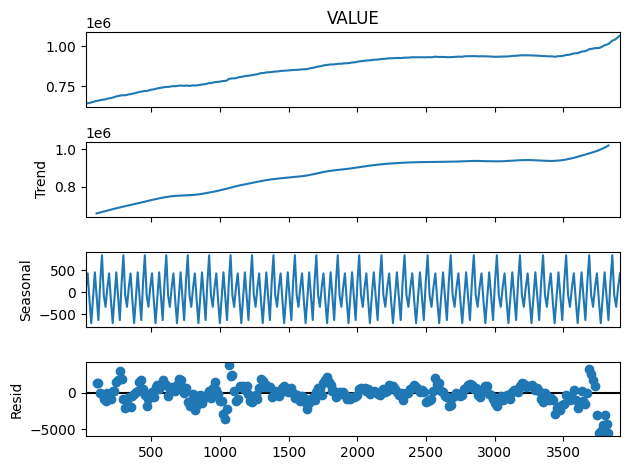

(1.5814559725356148, 0.9978008618141408, 13, 276, {'1%': -3.4542672521624214, '5%': -2.87206958769775, '10%': -2.5723807881747534}, 4628.07700371762)
Forecasted Values for the Next 12 Months:
2024-01-01    1.070947e+06
2024-04-01    1.078553e+06
2024-07-01    1.089443e+06
2024-10-01    1.097166e+06
Freq: QS-OCT, Name: predicted_mean, dtype: float64


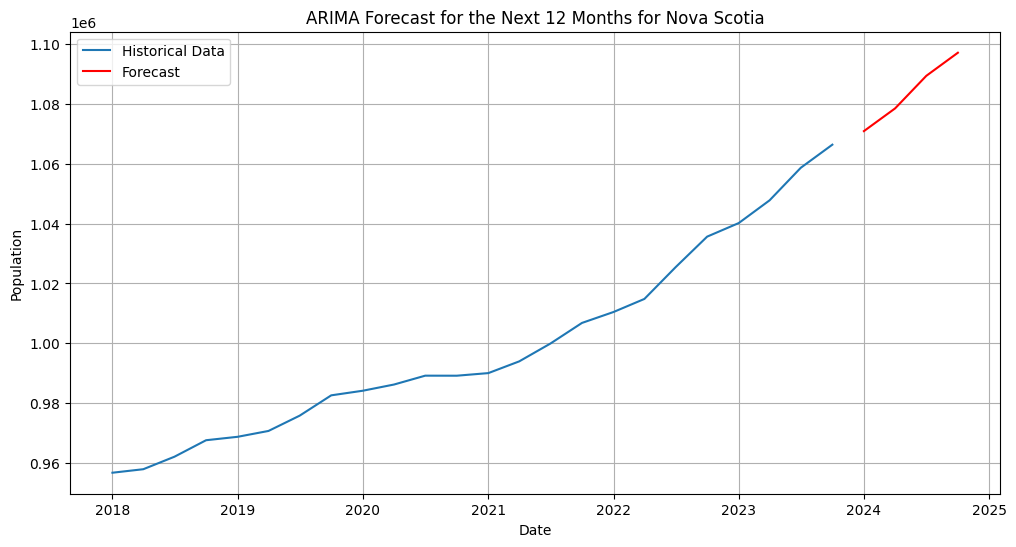

Mean Absolute Error (MAE): 2045.17
Root Mean Squared Error (RMSE): 2395.39
R-squared (R2): 0.96
Mean Absolute Percentage Error (MAPE): 0.20%
[1066416]
Total predicted population 2024: [23026.9625082]
Total People 23026.962508195546
House needed as per 3 people in a house: 7676
House available: 6303
Total houses needed:  1373
Level of Housing Crisis (out of 100): 17.886920270974464 %
House needed as per 3 people in a house: 7676
House available: 6303
      geo_name  Total People  House needed (3 people per house)  \
0  Nova Scotia  23026.962508                               7676   

   House available  Total houses needed  per_of_cris  
0             6303                 1373     17.88692  


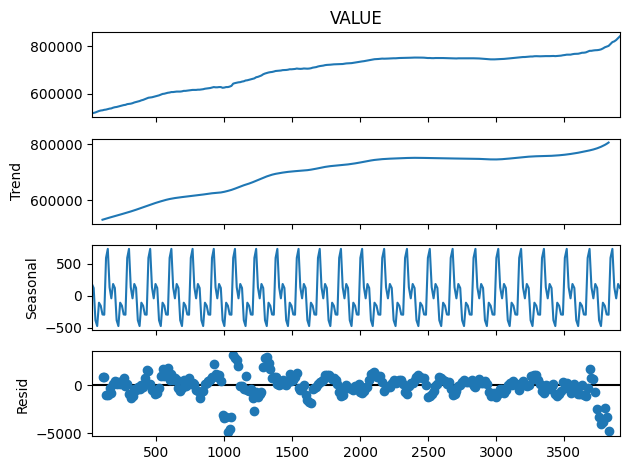

(0.5182581461768173, 0.9854175993600528, 7, 282, {'1%': -3.4537536300652, '5%': -2.8718443180148836, '10%': -2.572260641818822}, 4544.009973796152)
Forecasted Values for the Next 12 Months:
2024-01-01    847083.469077
2024-04-01    851862.185226
2024-07-01    857218.962991
2024-10-01    862808.523776
Freq: QS-OCT, Name: predicted_mean, dtype: float64


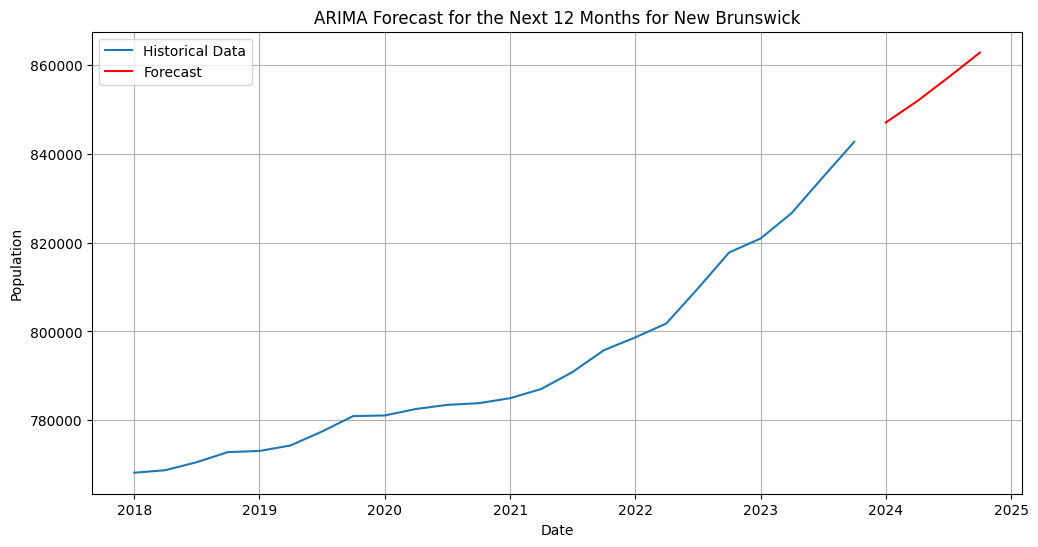

Mean Absolute Error (MAE): 1445.30
Root Mean Squared Error (RMSE): 1909.04
R-squared (R2): 0.96
Mean Absolute Percentage Error (MAPE): 0.17%
[842725]
Total predicted population 2024: [14493.9629912]
Total People 14493.962991196197
House needed as per 3 people in a house: 4832
House available: 3972
Total houses needed:  860
Level of Housing Crisis (out of 100): 17.79801324503311 %
House needed as per 3 people in a house: 4832
House available: 3972
        geo_name  Total People  House needed (3 people per house)  \
0  New Brunswick  14493.962991                               4832   

   House available  Total houses needed  per_of_cris  
0             3972                  860    17.798013  


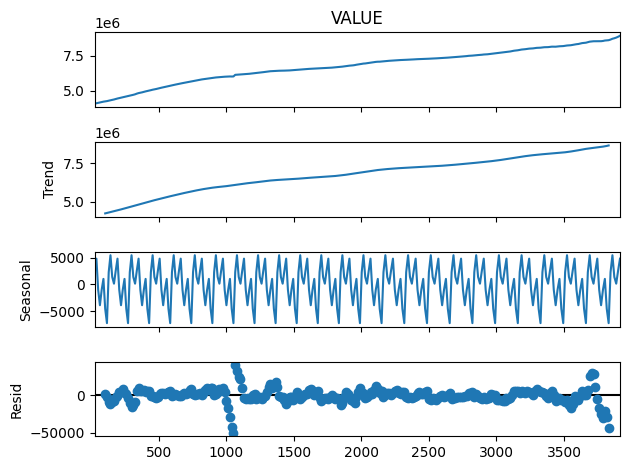

(1.3434323426616743, 0.9968413821004306, 16, 273, {'1%': -3.45453261164607, '5%': -2.8721859575020017, '10%': -2.572442854861866}, 5769.785102774502)
Forecasted Values for the Next 12 Months:
2024-01-01    8.988090e+06
2024-04-01    9.035993e+06
2024-07-01    9.093694e+06
2024-10-01    9.167999e+06
Freq: QS-OCT, Name: predicted_mean, dtype: float64


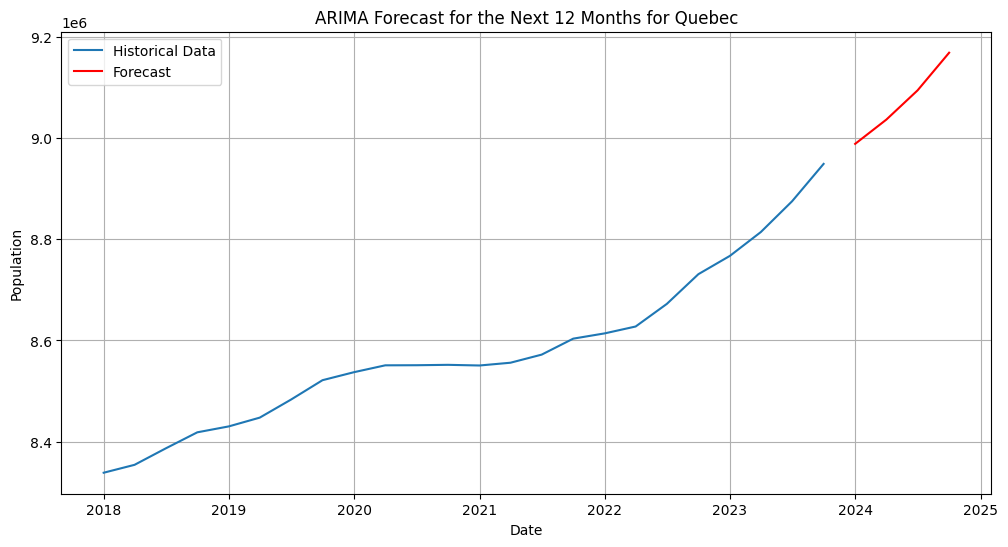

Mean Absolute Error (MAE): 22582.87
Root Mean Squared Error (RMSE): 23369.55
R-squared (R2): 0.91
Mean Absolute Percentage Error (MAPE): 0.26%
[8948540]
Total predicted population 2024: [145153.93087709]
Total People 145153.93087709323
House needed as per 3 people in a house: 48385
House available: 32584
Total houses needed:  15801
Level of Housing Crisis (out of 100): 32.65681512865557 %
House needed as per 3 people in a house: 48385
House available: 32584
  geo_name   Total People  House needed (3 people per house)  House available  \
0   Quebec  145153.930877                              48385            32584   

   Total houses needed  per_of_cris  
0                15801    32.656815  


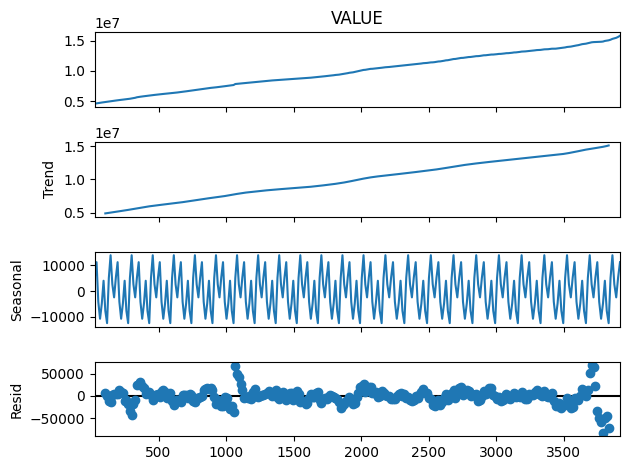

(1.7626932428258804, 0.9982720827874954, 16, 273, {'1%': -3.45453261164607, '5%': -2.8721859575020017, '10%': -2.572442854861866}, 6035.186654152354)
Forecasted Values for the Next 12 Months:
2024-01-01    1.589610e+07
2024-04-01    1.597497e+07
2024-07-01    1.612620e+07
2024-10-01    1.631953e+07
Freq: QS-OCT, Name: predicted_mean, dtype: float64


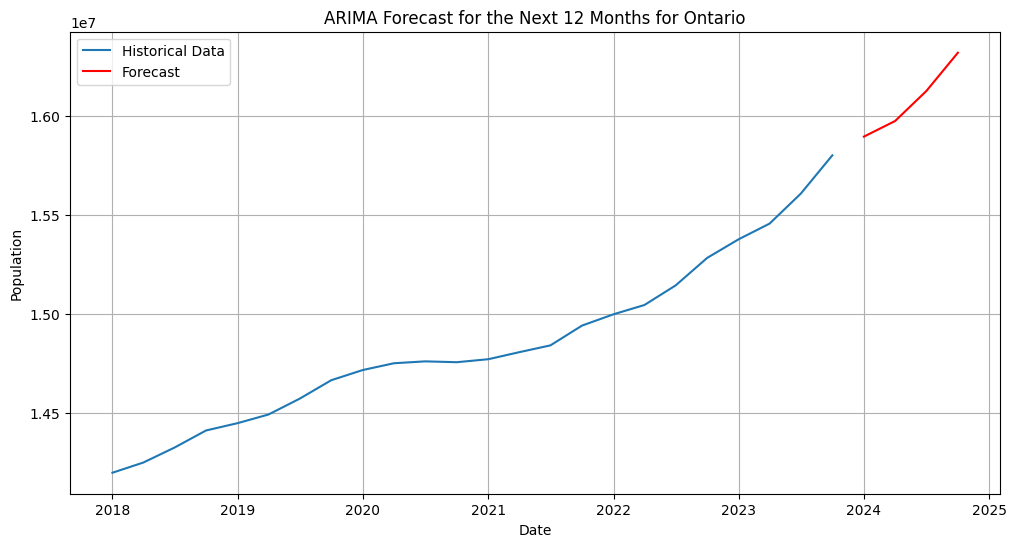

Mean Absolute Error (MAE): 43003.16
Root Mean Squared Error (RMSE): 43911.75
R-squared (R2): 0.94
Mean Absolute Percentage Error (MAPE): 0.28%
[15801768]
Total predicted population 2024: [324429.53753618]
Total People 324429.53753617965
House needed as per 3 people in a house: 108144
House available: 85770
Total houses needed:  22374
Level of Housing Crisis (out of 100): 20.68908122503329 %
House needed as per 3 people in a house: 108144
House available: 85770
  geo_name   Total People  House needed (3 people per house)  House available  \
0  Ontario  324429.537536                             108144            85770   

   Total houses needed  per_of_cris  
0                22374    20.689081  


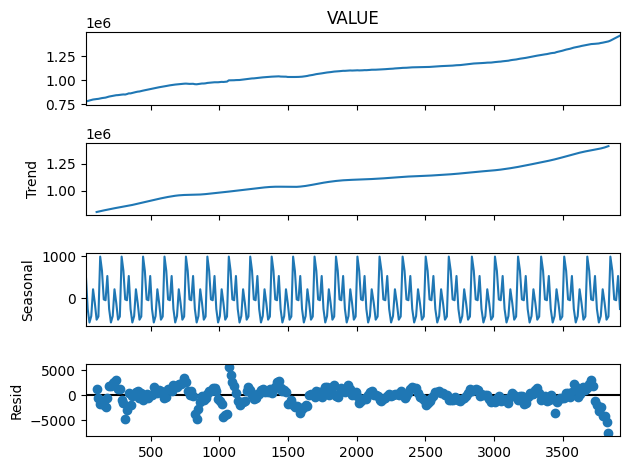

(1.7892253308312394, 0.99832740610621, 6, 283, {'1%': -3.453670163592738, '5%': -2.8718077069772248, '10%': -2.5722411158835796}, 4743.200671471021)
Forecasted Values for the Next 12 Months:
2024-01-01    1.474088e+06
2024-04-01    1.486633e+06
2024-07-01    1.495180e+06
2024-10-01    1.500785e+06
Freq: QS-OCT, Name: predicted_mean, dtype: float64


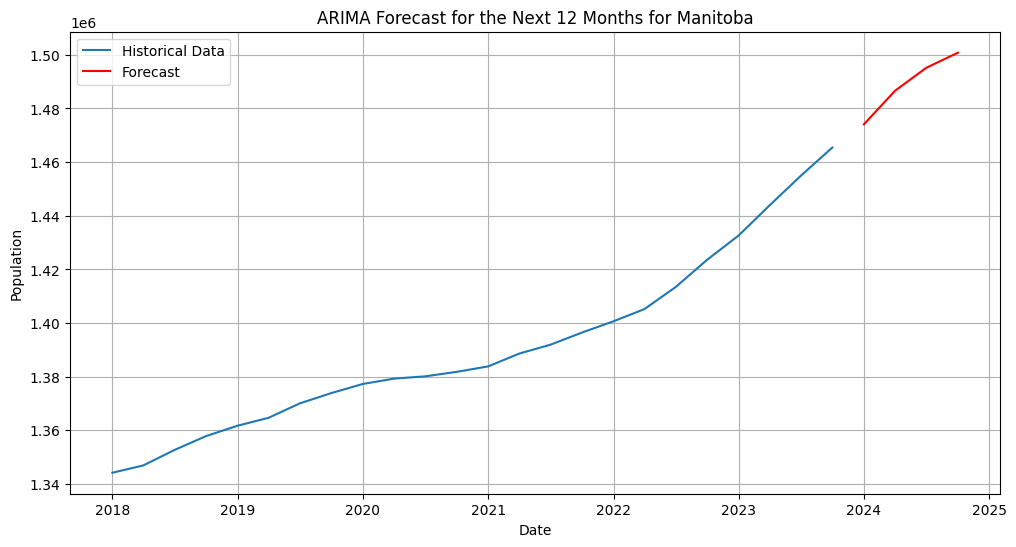

Mean Absolute Error (MAE): 3328.58
Root Mean Squared Error (RMSE): 4640.32
R-squared (R2): 0.90
Mean Absolute Percentage Error (MAPE): 0.23%
[1465440]
Total predicted population 2024: [29740.28784469]
Total People 29740.287844686536
House needed as per 3 people in a house: 9914
House available: 6137
Total houses needed:  3777
Level of Housing Crisis (out of 100): 38.097639701432314 %
House needed as per 3 people in a house: 9914
House available: 6137
   geo_name  Total People  House needed (3 people per house)  House available  \
0  Manitoba  29740.287845                               9914             6137   

   Total houses needed  per_of_cris  
0                 3777     38.09764  


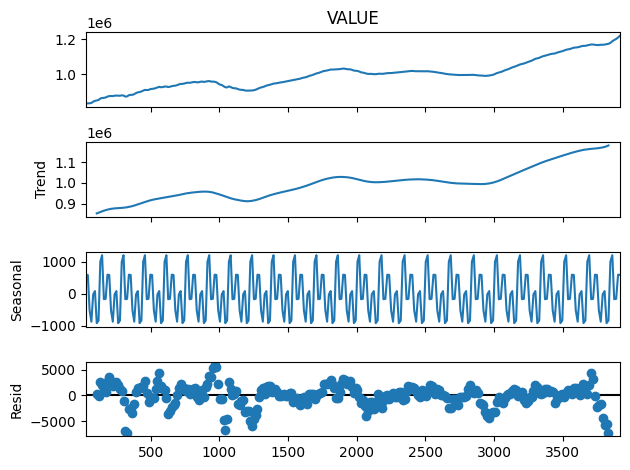

(1.2146215193111838, 0.9960853634154437, 13, 276, {'1%': -3.4542672521624214, '5%': -2.87206958769775, '10%': -2.5723807881747534}, 4708.462409358098)
Forecasted Values for the Next 12 Months:
2024-01-01    1.224347e+06
2024-04-01    1.227653e+06
2024-07-01    1.234210e+06
2024-10-01    1.240197e+06
Freq: QS-OCT, Name: predicted_mean, dtype: float64


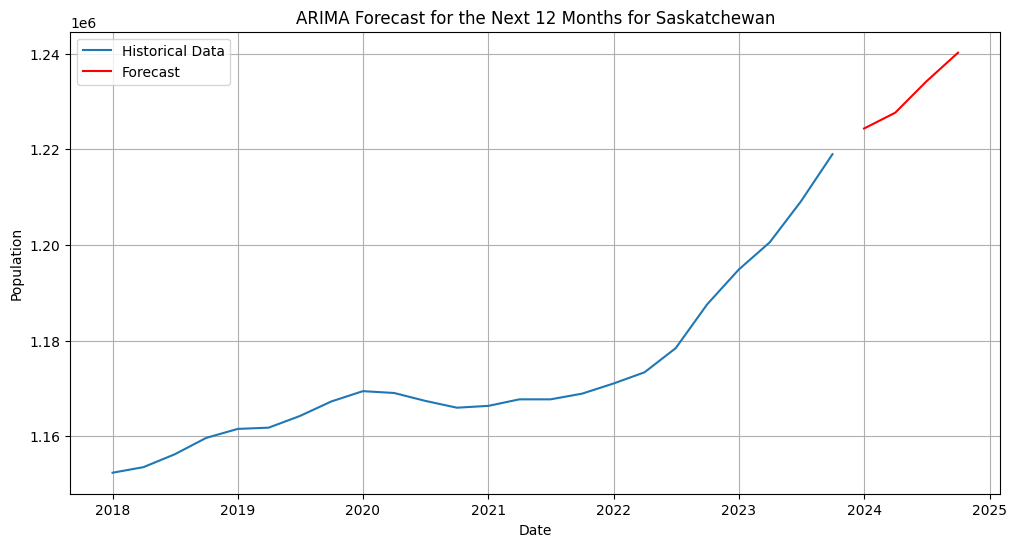

Mean Absolute Error (MAE): 2724.20
Root Mean Squared Error (RMSE): 3016.59
R-squared (R2): 0.92
Mean Absolute Percentage Error (MAPE): 0.23%
[1218976]
Total predicted population 2024: [15234.03974159]
Total People 15234.039741594577
House needed as per 3 people in a house: 5079
House available: 4210
Total houses needed:  869
Level of Housing Crisis (out of 100): 17.10966725733412 %
House needed as per 3 people in a house: 5079
House available: 4210
       geo_name  Total People  House needed (3 people per house)  \
0  Saskatchewan  15234.039742                               5079   

   House available  Total houses needed  per_of_cris  
0             4210                  869    17.109667  


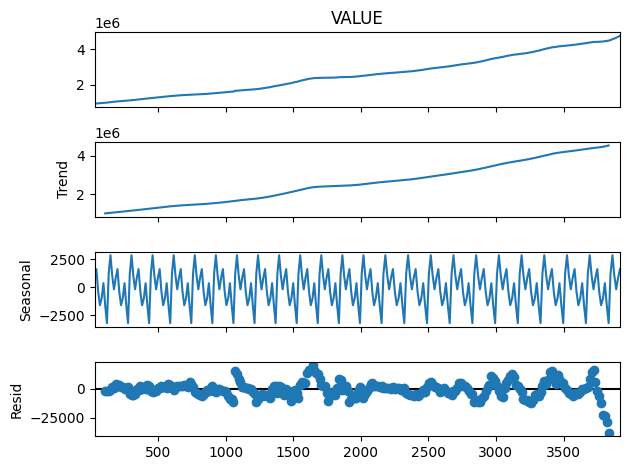

(2.4503419868706624, 0.9990320653607134, 12, 277, {'1%': -3.4541800885158525, '5%': -2.872031361137725, '10%': -2.5723603999791473}, 5388.9376380155545)
Forecasted Values for the Next 12 Months:
2024-01-01    4.794361e+06
2024-04-01    4.851578e+06
2024-07-01    4.900655e+06
2024-10-01    4.951454e+06
Freq: QS-OCT, Name: predicted_mean, dtype: float64


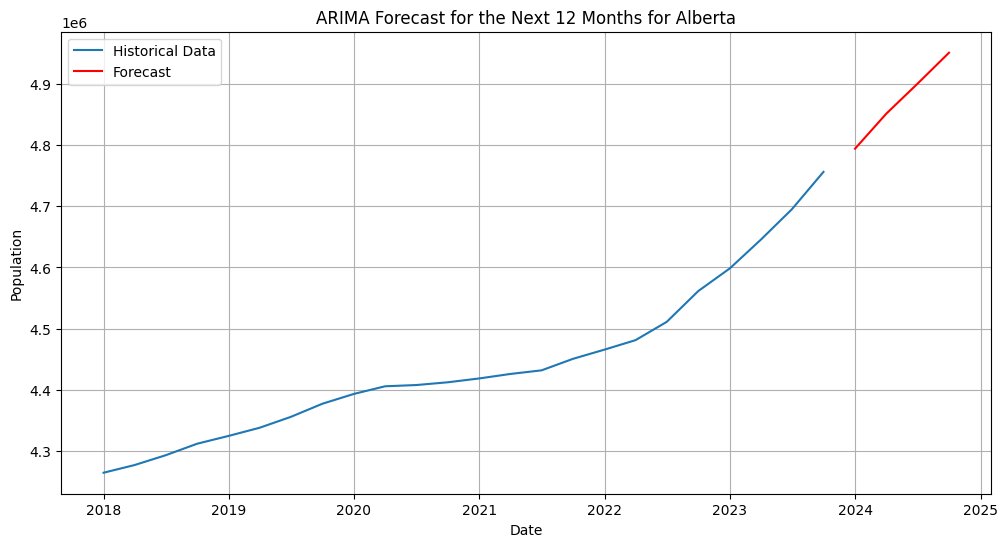

Mean Absolute Error (MAE): 12113.48
Root Mean Squared Error (RMSE): 15020.80
R-squared (R2): 0.95
Mean Absolute Percentage Error (MAPE): 0.26%
[4756408]
Total predicted population 2024: [144246.80155323]
Total People 144246.80155322794
House needed as per 3 people in a house: 48083
House available: 35225
Total houses needed:  12858
Level of Housing Crisis (out of 100): 26.741259904748038 %
House needed as per 3 people in a house: 48083
House available: 35225
  geo_name   Total People  House needed (3 people per house)  House available  \
0  Alberta  144246.801553                              48083            35225   

   Total houses needed  per_of_cris  
0                12858     26.74126  


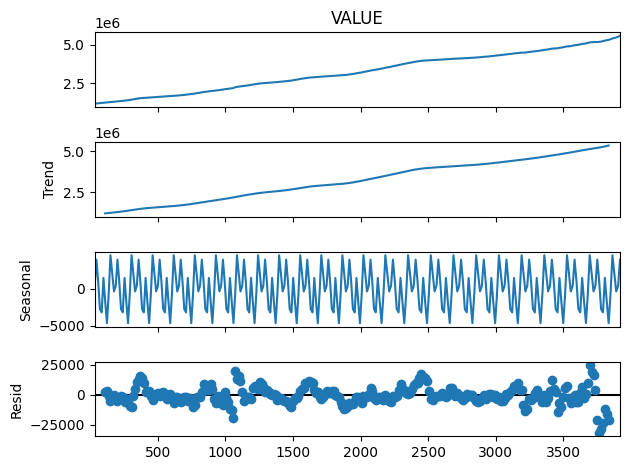

(1.5831859844485094, 0.9978062452282344, 13, 276, {'1%': -3.4542672521624214, '5%': -2.87206958769775, '10%': -2.5723807881747534}, 5542.231779402806)
Forecasted Values for the Next 12 Months:
2024-01-01    5.616756e+06
2024-04-01    5.661850e+06
2024-07-01    5.730192e+06
2024-10-01    5.803952e+06
Freq: QS-OCT, Name: predicted_mean, dtype: float64


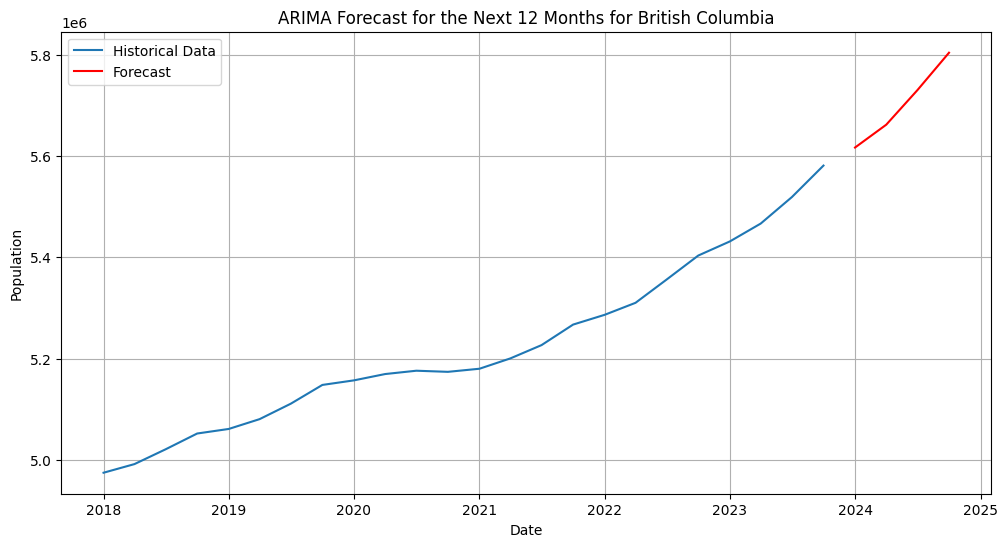

Mean Absolute Error (MAE): 4007.75
Root Mean Squared Error (RMSE): 4173.47
R-squared (R2): 1.00
Mean Absolute Percentage Error (MAPE): 0.07%
[5581127]
Total predicted population 2024: [149065.23615453]
Total People 149065.236154533
House needed as per 3 people in a house: 49689
House available: 47895
Total houses needed:  1794
Level of Housing Crisis (out of 100): 3.610457042806255 %
House needed as per 3 people in a house: 49689
House available: 47895
           geo_name   Total People  House needed (3 people per house)  \
0  British Columbia  149065.236155                              49689   

   House available  Total houses needed  per_of_cris  
0            47895                 1794     3.610457  


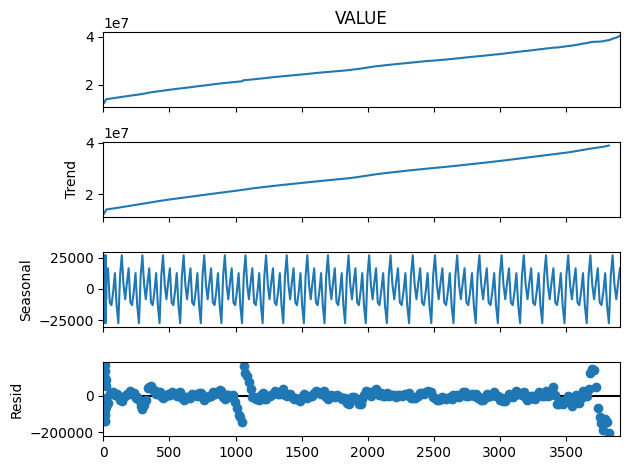

(1.9122073105522792, 0.9985474077209189, 16, 295, {'1%': -3.452713099849546, '5%': -2.871387839457783, '10%': -2.5720171933352485}, 7028.5636013916055)
Forecasted Values for the Next 12 Months:
2024-01-01    4.082429e+07
2024-04-01    4.115983e+07
2024-07-01    4.158883e+07
2024-10-01    4.208127e+07
Freq: QS-OCT, Name: predicted_mean, dtype: float64


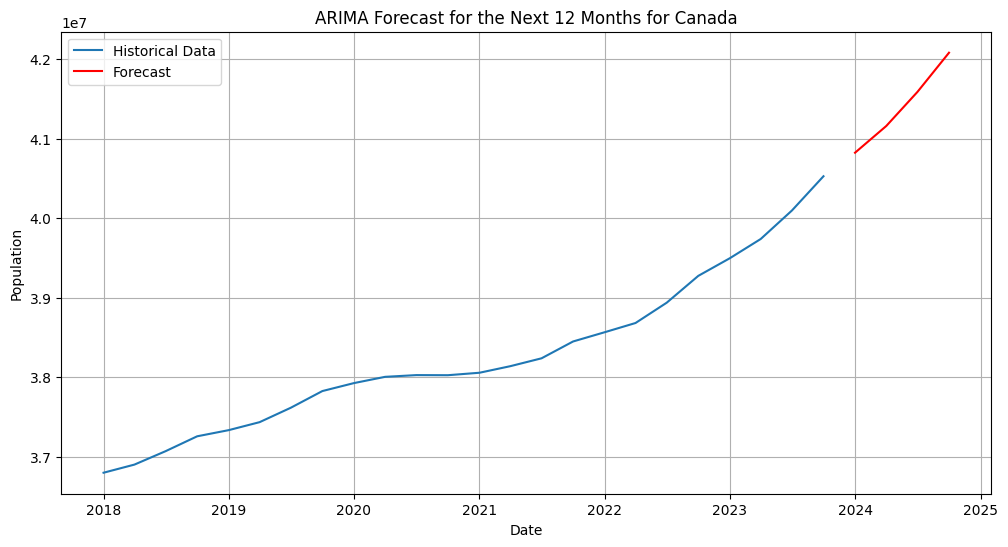

Mean Absolute Error (MAE): 103060.52
Root Mean Squared Error (RMSE): 115364.43
R-squared (R2): 0.93
Mean Absolute Percentage Error (MAPE): 0.26%
[40528396]
Total predicted population 2024: [1060435.79570082]
Total People 1060435.7957008183
House needed as per 3 people in a house: 353479
House available: 223197
Total houses needed:  130282
Level of Housing Crisis (out of 100): 36.857069302561115 %
House needed as per 3 people in a house: 353479
House available: 223197
  geo_name  Total People  House needed (3 people per house)  House available  \
0   Canada  1.060436e+06                             353479           223197   

   Total houses needed  per_of_cris  
0               130282    36.857069  


In [176]:
for geo_name in geo_names:
    process_geo_for_population(geo_name)

In [177]:
# Save the DataFrame to a CSV file
# Concatenate all predicted values DataFrames in the list

predicted_values_df = pd.concat(predicted_values_list, ignore_index=True)
# Save the DataFrame to a CSV file
predicted_values_df.to_csv('predicted_values.csv', index=False)
forecasted_values_df = pd.concat(forecasted_values_list, ignore_index=True)

combined_df = pd.concat([population_data_main, forecasted_values_df], ignore_index=True)

combined_df.to_csv('population_data_with_2024.csv', index=False)

predicted_values_df

,geo_name,Total People,House needed (3 people per house),House available,Total houses needed,per_of_cris
0,Nova Scotia,2.302696e+04,7676,6303,1373,17.886920
1,New Brunswick,1.449396e+04,4832,3972,860,17.798013
2,Quebec,1.451539e+05,48385,32584,15801,32.656815
3,Ontario,3.244295e+05,108144,85770,22374,20.689081
4,Manitoba,2.974029e+04,9914,6137,3777,38.097640
5,Saskatchewan,1.523404e+04,5079,4210,869,17.109667
6,Alberta,1.442468e+05,48083,35225,12858,26.741260
7,British Columbia,1.490652e+05,49689,47895,1794,3.610457
8,Canada,1.060436e+06,353479,223197,130282,36.857069


#House Price Forecasting

In [178]:
houseselling_data_copy = pd.read_excel("/content/drive/MyDrive/Capstone Project/House_sellin_2020-2023.xlsx")
houseselling_data_copy.head(2)

houseselling_data_copy = houseselling_data_copy[houseselling_data_copy['GEO'] == geo_name]

columns = ['DGUID', 'UOM','UOM_ID','SCALAR_FACTOR','SCALAR_ID','SCALAR_ID','VECTOR','COORDINATE','STATUS','SYMBOL','TERMINATED','DECIMALS']
houseselling_data = houseselling_data_copy.drop(columns, axis=1)

House_total_price = houseselling_data[houseselling_data['New housing price indexes'] == 'Total (house and land)']
House_only_total = houseselling_data[houseselling_data['New housing price indexes'] == 'House only']
Land_only_total = houseselling_data[houseselling_data['New housing price indexes'] == 'Land only']

House_total_price.columns

#change House_total_price to House_only_total and Land_only_total one by one and run all to see forecast
selected_data = House_total_price[['REF_DATE', 'VALUE']]
selected_data = selected_data.sort_values(by='REF_DATE')

# Assuming selected_data is your DataFrame

# Convert 'REF_DATE' column to datetime
selected_data['REF_DATE'] = pd.to_datetime(selected_data['REF_DATE'])

# Select data with a year less than 2023
selected_data = selected_data[selected_data['REF_DATE'].dt.year <= 2023]
selected_data.head(2)
selected_data.set_index('REF_DATE', inplace=True)


# Assuming selected_data is your DataFrame containing the time series data
# Assuming 'VALUE' is the column you want to forecast

# Prepare the data
data = selected_data['VALUE'].values.reshape(-1, 1)  # Convert to 2D array for scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Define sequence length
sequence_length = 6  # Adjust according to your data and task

# Create sequences
X, y = create_sequences(scaled_data, sequence_length)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=70, batch_size=1)

# Generate input sequence for the next 24 months
future_sequence = scaled_data[-sequence_length:].reshape(1, sequence_length, 1)
future_predictions = []

period = 24
# Make predictions for the next 24 months
for i in range(period):
    prediction = model.predict(future_sequence)
    future_predictions.append(prediction)
    future_sequence = np.append(future_sequence[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

# Inverse scale the predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Generate dates for the next 24 months
last_date = selected_data.index[-1]
future_dates = pd.date_range(start=last_date, periods=period+1, freq='M')[1:]  # Exclude the current month

# Calculate accuracy metrics
actual_values = selected_data['VALUE'].values[-period:]
predicted_values = future_predictions.flatten()

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predicted_values)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_values, predicted_values)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)

# Visualize the predictions
plt.plot(selected_data.index, selected_data['VALUE'], label='Actual')
plt.plot(future_dates, future_predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Total land and HOUSE price indexes')
plt.title('LSTM ModelTotal land and HOUSE price Forecast for Next 24 Months')
plt.legend()
plt.show()

In [179]:
# houseselling_data_copy = pd.read_excel("/content/drive/MyDrive/Capstone Project/House_sellin_2020-2023.xlsx")
# houseselling_data_copy.head(2)

# houseselling_data_copy = houseselling_data_copy[houseselling_data_copy['GEO'] == geo_name]

# columns = ['DGUID', 'UOM','UOM_ID','SCALAR_FACTOR','SCALAR_ID','SCALAR_ID','VECTOR','COORDINATE','STATUS','SYMBOL','TERMINATED','DECIMALS']
# houseselling_data = houseselling_data_copy.drop(columns, axis=1)

# House_total_price = houseselling_data[houseselling_data['New housing price indexes'] == 'Total (house and land)']
# House_only_total = houseselling_data[houseselling_data['New housing price indexes'] == 'House only']
# Land_only_total = houseselling_data[houseselling_data['New housing price indexes'] == 'Land only']

# House_total_price.columns

# #change House_total_price to House_only_total and Land_only_total one by one and run all to see forecast
# selected_data = House_only_total[['REF_DATE', 'VALUE']]
# selected_data = selected_data.sort_values(by='REF_DATE')

# # Assuming selected_data is your DataFrame

# # Convert 'REF_DATE' column to datetime
# selected_data['REF_DATE'] = pd.to_datetime(selected_data['REF_DATE'])

# # Select data with a year less than 2023
# selected_data = selected_data[selected_data['REF_DATE'].dt.year <= 2023]
# selected_data.head(2)
# selected_data.set_index('REF_DATE', inplace=True)


# # Assuming selected_data is your DataFrame containing the time series data
# # Assuming 'VALUE' is the column you want to forecast

# # Prepare the data
# data = selected_data['VALUE'].values.reshape(-1, 1)  # Convert to 2D array for scaling
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_data = scaler.fit_transform(data)

# # Function to create sequences for LSTM
# def create_sequences(data, seq_length):
#     X, y = [], []
#     for i in range(len(data) - seq_length):
#         X.append(data[i:i+seq_length])
#         y.append(data[i+seq_length])
#     return np.array(X), np.array(y)

# # Define sequence length
# sequence_length = 6  # Adjust according to your data and task

# # Create sequences
# X, y = create_sequences(scaled_data, sequence_length)

# # Build the LSTM model
# model = Sequential()
# model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
# model.add(LSTM(units=50))
# model.add(Dense(units=1))

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Train the model
# model.fit(X, y, epochs=70, batch_size=1)

# # Generate input sequence for the next 24 months
# future_sequence = scaled_data[-sequence_length:].reshape(1, sequence_length, 1)
# future_predictions = []

# period = 24
# # Make predictions for the next 24 months
# for i in range(period):
#     prediction = model.predict(future_sequence)
#     future_predictions.append(prediction)
#     future_sequence = np.append(future_sequence[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

# # Inverse scale the predictions
# future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# # Generate dates for the next 24 months
# last_date = selected_data.index[-1]
# future_dates = pd.date_range(start=last_date, periods=period+1, freq='M')[1:]  # Exclude the current month

# # Calculate accuracy metrics
# actual_values = selected_data['VALUE'].values[-period:]
# predicted_values = future_predictions.flatten()

# # Calculate Mean Squared Error (MSE)
# mse = mean_squared_error(actual_values, predicted_values)

# # Calculate Root Mean Squared Error (RMSE)
# rmse = np.sqrt(mse)

# # Calculate Mean Absolute Error (MAE)
# mae = mean_absolute_error(actual_values, predicted_values)

# # Calculate Mean Absolute Percentage Error (MAPE)
# mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100

# print("Mean Squared Error (MSE):", mse)
# print("Root Mean Squared Error (RMSE):", rmse)
# print("Mean Absolute Error (MAE):", mae)
# print("Mean Absolute Percentage Error (MAPE):", mape)

# # Visualize the predictions
# plt.plot(selected_data.index, selected_data['VALUE'], label='Actual')
# plt.plot(future_dates, future_predictions, label='Predicted')
# plt.xlabel('Date')
# plt.ylabel('Total HOUSE price indexes')
# plt.title('HOUSE price Forecast for Next 24 Months')
# plt.legend()
# plt.show()

In [180]:
# houseselling_data_copy = pd.read_excel("/content/drive/MyDrive/Capstone Project/House_sellin_2020-2023.xlsx")
# houseselling_data_copy.head(2)

# houseselling_data_copy = houseselling_data_copy[houseselling_data_copy['GEO'] == geo_name]

# columns = ['DGUID', 'UOM','UOM_ID','SCALAR_FACTOR','SCALAR_ID','SCALAR_ID','VECTOR','COORDINATE','STATUS','SYMBOL','TERMINATED','DECIMALS']
# houseselling_data = houseselling_data_copy.drop(columns, axis=1)

# House_total_price = houseselling_data[houseselling_data['New housing price indexes'] == 'Total (house and land)']
# House_only_total = houseselling_data[houseselling_data['New housing price indexes'] == 'House only']
# Land_only_total = houseselling_data[houseselling_data['New housing price indexes'] == 'Land only']

# House_total_price.columns

# #change House_total_price to House_only_total and Land_only_total one by one and run all to see forecast
# selected_data = House_only_total[['REF_DATE', 'VALUE']]
# selected_data = selected_data.sort_values(by='REF_DATE')

# # Assuming selected_data is your DataFrame

# # Convert 'REF_DATE' column to datetime
# selected_data['REF_DATE'] = pd.to_datetime(selected_data['REF_DATE'])

# # Select data with a year less than 2023
# selected_data = selected_data[selected_data['REF_DATE'].dt.year <= 2023]
# selected_data.head(2)
# selected_data.set_index('REF_DATE', inplace=True)


# # Assuming selected_data is your DataFrame containing the time series data
# # Assuming 'VALUE' is the column you want to forecast

# # Prepare the data
# data = selected_data['VALUE'].values.reshape(-1, 1)  # Convert to 2D array for scaling
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_data = scaler.fit_transform(data)

# # Function to create sequences for LSTM
# def create_sequences(data, seq_length):
#     X, y = [], []
#     for i in range(len(data) - seq_length):
#         X.append(data[i:i+seq_length])
#         y.append(data[i+seq_length])
#     return np.array(X), np.array(y)

# # Define sequence length
# sequence_length = 6  # Adjust according to your data and task

# # Create sequences
# X, y = create_sequences(scaled_data, sequence_length)

# # Build the LSTM model
# model = Sequential()
# model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
# model.add(LSTM(units=50))
# model.add(Dense(units=1))

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Train the model
# model.fit(X, y, epochs=70, batch_size=1)

# # Generate input sequence for the next 24 months
# future_sequence = scaled_data[-sequence_length:].reshape(1, sequence_length, 1)
# future_predictions = []

# period = 24
# # Make predictions for the next 24 months
# for i in range(period):
#     prediction = model.predict(future_sequence)
#     future_predictions.append(prediction)
#     future_sequence = np.append(future_sequence[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

# # Inverse scale the predictions
# future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# # Generate dates for the next 24 months
# last_date = selected_data.index[-1]
# future_dates = pd.date_range(start=last_date, periods=period+1, freq='M')[1:]  # Exclude the current month

# # Calculate accuracy metrics
# actual_values = selected_data['VALUE'].values[-period:]
# predicted_values = future_predictions.flatten()

# # Calculate Mean Squared Error (MSE)
# mse = mean_squared_error(actual_values, predicted_values)

# # Calculate Root Mean Squared Error (RMSE)
# rmse = np.sqrt(mse)

# # Calculate Mean Absolute Error (MAE)
# mae = mean_absolute_error(actual_values, predicted_values)

# # Calculate Mean Absolute Percentage Error (MAPE)
# mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100

# print("Mean Squared Error (MSE):", mse)
# print("Root Mean Squared Error (RMSE):", rmse)
# print("Mean Absolute Error (MAE):", mae)
# print("Mean Absolute Percentage Error (MAPE):", mape)

# # Visualize the predictions
# plt.plot(selected_data.index, selected_data['VALUE'], label='Actual')
# plt.plot(future_dates, future_predictions, label='Predicted')
# plt.xlabel('Date')
# plt.ylabel('Total land price indexes')
# plt.title('Land price Forecast for Next 24 Months')
# plt.legend()
# plt.show()